# getting average response within series of consecutively moving ROIs in a row or column

## step-by-step

In [1]:
import lib.fileIngest as fileIngest
import lib.imgProcess as imgProcess
import lib.metadataProcess as metadataProcess
import re

xsgs = []
# dPaths = ["../data/AA0308","../data/AA0310","../data/AA0315"]
dPaths = [r"C:\Manoj Data\TL_B10_Mouse02\AA0001\Control"]

df = fileIngest.qcamPath2table(dPaths)
# df = fileIngest.qcamPath2table(dPaths,subfolder=True)

# Remove first few pre-exposing trials
df = df[df['qcam'].apply(lambda x: int(re.search(r'(\d{4})\.qcamraw$', x).group(1)) >= 30)]
df = df.dropna()

# Add pre- or post-injection labels
df['INJECTION'] = metadataProcess.getInjectionCond(df)

# Save and import joblib files
# joblib.dump(df,'../data/cache/TLB10-GRISZ.joblib')
# df = joblib.load('../data/cache/TLB10-GRISZ.joblib')

df

,qcam,dir,xsg,pulse,dB,INJECTION
3,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_80dB_10000msTotal_Fs250kHz,80,CTRL
4,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_55dB_10000msTotal_Fs250kHz,55,CTRL
5,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_70dB_10000msTotal_Fs250kHz,70,CTRL
6,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_45dB_10000msTotal_Fs250kHz,45,CTRL
7,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_50dB_10000msTotal_Fs250kHz,50,CTRL
...,...,...,...,...,...,...
85,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_65dB_10000msTotal_Fs250kHz,65,CTRL
86,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_70dB_10000msTotal_Fs250kHz,70,CTRL
87,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_30dB_10000msTotal_Fs250kHz,30,CTRL
88,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_80dB_10000msTotal_Fs250kHz,80,CTRL


In [2]:
# Extract image arrays and spatial baseline or dFF

# dB = 80
# df = df[df['dB']==dB]
qcams = df['qcam'].tolist()
# qcamspre = df[df['INJECTION']=='preZX1']['qcam'].tolist()

# optionally change stimlen and temporalAvgFrameSpan, or t_temporalAvg to isolate spatial response
_, _, imgs, spatialDFF = imgProcess.qcams2roiTrace(qcams, baseline=True)
# _, _, imgs, spatialDFF = imgProcess.qcams2roiTrace(qcams, t_baseline=(2,3), t_temporalAvg=(3,3.3))

imgs.shape

(87, 130, 174, 200)

array([[35.        , 40.        ],
       [38.        , 40.        ],
       [29.33974596, 55.        ],
       [26.33974596, 55.        ],
       [35.        , 40.        ]])

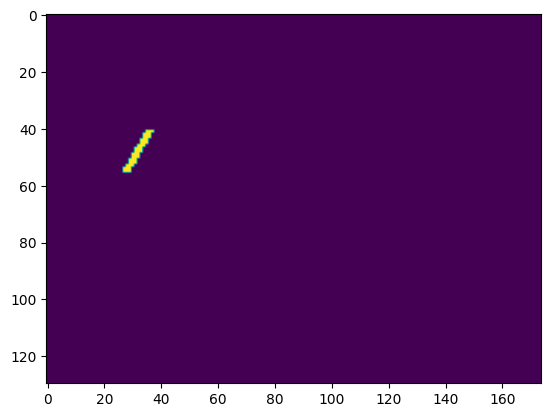

In [3]:
# Manually set the binary mask

import matplotlib.pyplot as plt
mask = imgProcess.getSquareMask(35, 40, 3, 15, angle=120)

# Show the contour and shape
plt.imshow(mask['mask'])
mask['ROIcontour']

In [4]:
# Create a dataframe including metadata within each ROI

import numpy as np
import pandas as pd
import lib.signalProcess as signalProcess

# Define shift parameters
num_shifts = 35    # Shift counts
shift_step = 3    # Step size

# Extract the original mask and contour
original_mask = mask['mask'].copy()
original_contour = mask['ROIcontour'].copy()

# Initialize DataFrame storage
mask_data = []

for i in range(0, num_shifts):
    # Compute new contour positions (x + shift_step*i)
    shifted_contour = original_contour.copy()
    # Move X-coordinates rightwards
    shifted_contour[:, 0] += shift_step*i
    # Move X-coordinates leftwards
    # shifted_contour[:, 0] -= shift_step*i
    # Move Y-coordinates downwards
    # shifted_contour[:, 1] += shift_step*i

    # Ensure contour does not exceed image boundaries
    if np.any(shifted_contour[:, 0] >= mask['mask'].shape[1]):
        print(f"Stopped at shift {i}: Contour exceeds boundaries.")
        break  # Stop if any point exceeds the image width

    # Extract the X-coordinate of the top-left vertex for positioning
    shifted_position = shifted_contour.tolist()[0][0]

    # Shift mask rightward
    shifted_mask = np.roll(original_mask, shift_step*i, axis=1)

    # Append results to list
    mask_data.append([shifted_mask, shifted_contour, shifted_position])

# Convert to DataFrame
df_mask = pd.DataFrame(mask_data, columns=["mask", "ROIcontour", "position"])

# Show the shifted mask
# plt.imshow(df_mask['mask'].iloc[29])

df_mask['Froi'] = df_mask['mask'].apply(lambda x: imgs[:, x == 1, :].mean(axis=(0,1)))
df_mask['dFF'], df_mask['dF'], df_mask['f0'] = zip(*df_mask['Froi'].apply(lambda x: signalProcess.dFFcalc(x, t_base = (2,3))))
df_mask['t'] = df_mask.apply(lambda x: signalProcess.getTimeVec(imgs.shape[-1]), axis=1)

pd.set_option('display.max_rows', 10)
df_mask

,mask,ROIcontour,position,Froi,dFF,dF,f0,t
0,"[[False, False, False, False, False, False, Fa...","[[35.0, 40.0], [38.0, 40.0], [29.3397459621556...",35.0,"[205.21685823754788, 204.95862068965516, 204.6...","[0.009880481563098488, 0.008609684117589906, 0...","[2.0078033205619477, 1.7495657726692286, 1.459...",203.209055,"[0.02500000000000001, 0.075, 0.125, 0.175, 0.2..."
1,"[[False, False, False, False, False, False, Fa...","[[38.0, 40.0], [41.0, 40.0], [32.3397459621556...",38.0,"[256.47816091954024, 256.1831417624521, 255.81...","[0.009726280062402953, 0.008564822123973708, 0...","[2.4705491698595097, 2.1755300127713895, 1.812...",254.007612,"[0.02500000000000001, 0.075, 0.125, 0.175, 0.2..."
2,"[[False, False, False, False, False, False, Fa...","[[41.0, 40.0], [44.0, 40.0], [35.3397459621556...",41.0,"[358.3287356321839, 358.13639846743297, 357.60...","[0.009440453582143129, 0.008898624542157388, 0...","[3.351149425287417, 3.158812260536479, 2.63135...",354.977586,"[0.02500000000000001, 0.075, 0.125, 0.175, 0.2..."
3,"[[False, False, False, False, False, False, Fa...","[[44.0, 40.0], [47.0, 40.0], [38.3397459621556...",44.0,"[496.6204342273308, 496.0457215836526, 495.559...","[0.009739207568256995, 0.00857068962293733, 0....","[4.790038314176229, 4.215325670498032, 3.72873...",491.830396,"[0.02500000000000001, 0.075, 0.125, 0.175, 0.2..."
4,"[[False, False, False, False, False, False, Fa...","[[47.0, 40.0], [50.0, 40.0], [41.3397459621556...",47.0,"[623.0212005108557, 622.4865900383141, 621.566...","[0.009838870839960991, 0.008972334620185651, 0...","[6.070102171136568, 5.535491698595024, 4.61544...",616.951098,"[0.02500000000000001, 0.075, 0.125, 0.175, 0.2..."
...,...,...,...,...,...,...,...,...
30,"[[False, False, False, False, False, False, Fa...","[[125.0, 40.0], [128.0, 40.0], [119.3397459621...",125.0,"[335.8045977011494, 335.46564495530015, 334.87...","[0.01178415794630459, 0.010762888372003235, 0....","[3.911085568326939, 3.57213282247767, 2.985159...",331.893512,"[0.02500000000000001, 0.075, 0.125, 0.175, 0.2..."
31,"[[False, False, False, False, False, False, Fa...","[[128.0, 40.0], [131.0, 40.0], [122.3397459621...",128.0,"[290.42605363984677, 290.1338441890166, 289.60...","[0.011334460489402811, 0.0103169158042703, 0.0...","[3.254929757343632, 2.962720306513461, 2.43117...",287.171124,"[0.02500000000000001, 0.075, 0.125, 0.175, 0.2..."
32,"[[False, False, False, False, False, False, Fa...","[[131.0, 40.0], [134.0, 40.0], [125.3397459621...",131.0,"[264.11034482758623, 263.75376756066413, 263.3...","[0.011685844654143357, 0.010319960354132124, 0...","[3.0507024265645555, 2.6941251596424536, 2.309...",261.059642,"[0.02500000000000001, 0.075, 0.125, 0.175, 0.2..."
33,"[[False, False, False, False, False, False, Fa...","[[134.0, 40.0], [137.0, 40.0], [128.3397459621...",134.0,"[259.44572158365264, 258.8199233716475, 258.50...","[0.01291783621132656, 0.010474619314397452, 0....","[3.308735632183925, 2.6829374201788028, 2.3700...",256.136986,"[0.02500000000000001, 0.075, 0.125, 0.175, 0.2..."


C:\Users\SHY200\AppData\Local\Temp\ipykernel_3904\1111088128.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


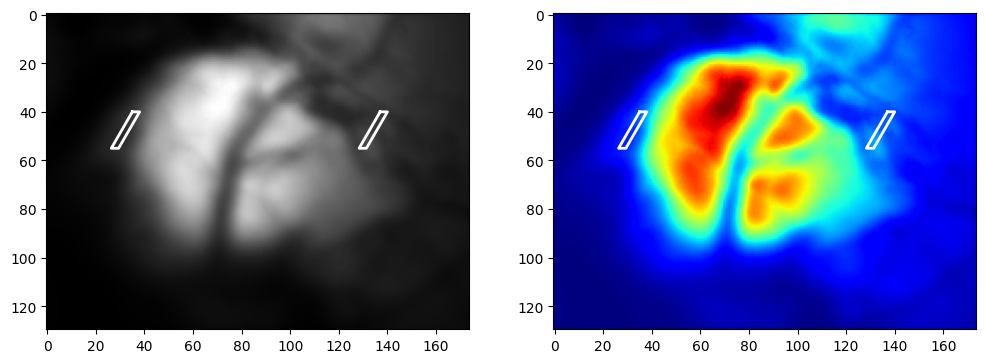

In [5]:
# Show the start and end positions of the mask

fig,ax = plt.subplots(1,2,figsize=(12,8))
ax[0].imshow(imgs.mean(axis=(0,3)), cmap='gray')
heatmapImg = ax[1].imshow(spatialDFF, cmap='jet')
ax[0].plot(mask['ROIcontour'][:, 0], mask['ROIcontour'][:, 1], color='w', linewidth=2)
ax[0].plot(df_mask['ROIcontour'].iloc[-1][:, 0], df_mask['ROIcontour'].iloc[-1][:, 1], color='w', linewidth=2)
ax[1].plot(mask['ROIcontour'][:, 0], mask['ROIcontour'][:, 1], color='w', linewidth=2)
ax[1].plot(df_mask['ROIcontour'].iloc[-1][:, 0], df_mask['ROIcontour'].iloc[-1][:, 1], color='w', linewidth=2)

fig.show()

In [6]:
# Display dFF response within all ROIs in one interactive plot

import plotly.express as px
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Expand 't' and 'dFF' to extend the dataframe into a long table
df_mask_reset = df_mask.explode(['t', 'dFF']).reset_index(drop=True)

# Get unique position counts
num_positions = df_mask_reset['position'].nunique()

# Generate a cool-to-warm colormap
colors = cm.coolwarm(np.linspace(0, 1, num_positions))

# Convert to HEX format
hex_colors = [mcolors.rgb2hex(color) for color in colors]

# Create the Plotly line plot
fig = px.line(
    df_mask_reset,
    x='t', 
    y='dFF', 
    color='position', 
    labels={'t': 'Time (s)', 'dFF': 'Fluorescence intensity', 'position': 'Position'}, 
    color_discrete_sequence=hex_colors
)

# Update layout
fig.update_layout(
    title="Fluorescence Response: Temperature <=> X Position",
    xaxis_title="Time (s)",
    yaxis_title="Fluorescence intensity (dFF)",
    legend_title="Position along X-axis"
)

fig.show()

c:\Users\SHY200\OneDrive - University of Pittsburgh\Documents\Python\pyFluo\env\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning:

Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.



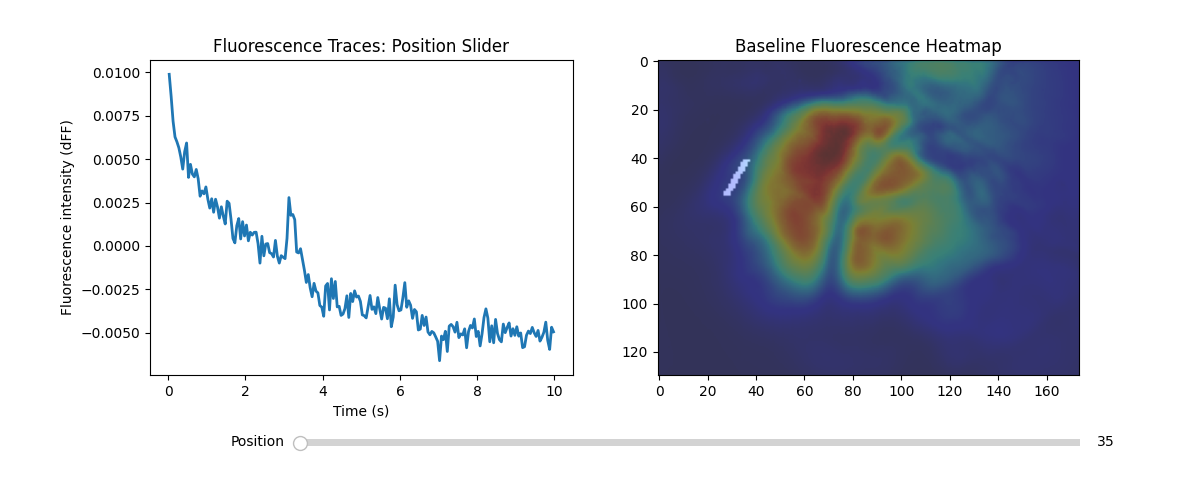

In [10]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Set plots backend to widget mode
# Render plots as an interactive window rather than PNG formats
%matplotlib widget

# Get unique positions and sort them
unique_positions = sorted(df_mask_reset['position'].unique())

# Initialize figure with two subplots (traces + heatmap)
fig, (ax_curve, ax_img) = plt.subplots(1, 2, figsize=(12, 5))

# Leave space for slider
plt.subplots_adjust(bottom=0.25)

# Set initial position
initial_position = unique_positions[0]
df_initial = df_mask_reset[df_mask_reset['position'] == initial_position]

# Plot fluorescence response within initial ROI
[line] = ax_curve.plot(df_initial['t'], df_initial['dFF'], lw=2)
ax_curve.set_xlabel('Time (s)')
ax_curve.set_ylabel('Fluorescence intensity (dFF)')
ax_curve.set_title('Fluorescence Traces: Position Slider')

# Load heatmap (vasculature image) as static background
heatmapImg = ax_img.imshow(spatialDFF, cmap='jet', alpha=0.6)

# Display initial mask overlay
initial_mask = df_mask[df_mask['position'] == initial_position]['mask'].values[0]
mask_overlay = ax_img.imshow(initial_mask, cmap='gray', alpha=0.5)

ax_img.set_title('Baseline Fluorescence Heatmap')

# Slider setup
ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
position_slider = Slider(
    ax=ax_slider,
    label="Position",
    valmin=min(unique_positions),
    valmax=max(unique_positions),
    valinit=initial_position,
    valstep=shift_step
)

# Define function to update response curves when moving slider
def update(val):
    df_selected = df_mask_reset[df_mask_reset['position'] == position_slider.val]
    
    # Update the fluorescence trace
    line.set_xdata(df_selected['t'])
    line.set_ydata(df_selected['dFF'])
    
    # Autoscale Y-axis
    ax_curve.relim()
    ax_curve.autoscale_view()
    
    # Update the mask image with correct shifting
    mask_selected = df_mask[df_mask['position'] == position_slider.val]['mask'].values[0]
    mask_overlay.set_data(mask_selected)
    
    fig.canvas.draw_idle()

# Connect slider to update function
position_slider.on_changed(update)

plt.show()

# Automatically switch back to inline backend
# Render the following plots as static images instead of interactive widgets
%matplotlib inline

## by function

In [16]:
import lib.fileIngest as fileIngest
import lib.imgProcess as imgProcess
import lib.metadataProcess as metadataProcess
import re

xsgs = []
# dPaths = ["../data/AA0308","../data/AA0310","../data/AA0315"]
dPaths = [r"C:\Manoj Data\TL_B10_Mouse02\AA0001\Control"]

df = fileIngest.qcamPath2table(dPaths)
# df = fileIngest.qcamPath2table(dPaths,subfolder=True)

# Remove first few pre-exposing trials
df = df[df['qcam'].apply(lambda x: int(re.search(r'(\d{4})\.qcamraw$', x).group(1)) >= 30)]
df = df.dropna()

# Add pre- or post-injection labels
df['INJECTION'] = metadataProcess.getInjectionCond(df)

# Save and import joblib files
# joblib.dump(df,'../data/cache/TLB10-GRISZ.joblib')
# df = joblib.load('../data/cache/TLB10-GRISZ.joblib')

# Extract image arrays and spatial baseline or dFF
# dB = 80
# df = df[df['dB']==dB]
qcams = df['qcam'].tolist()
# qcamspre = df[df['INJECTION']=='preZX1']['qcam'].tolist()

imgs = imgProcess.qcams2roiTrace(qcams, baseline=True)[2]
# imgs = imgProcess.qcams2roiTrace(qcams, t_baseline=(2,3), t_temporalAvg=(3,3.3))[2]

df

,qcam,dir,xsg,pulse,dB,INJECTION
3,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_80dB_10000msTotal_Fs250kHz,80,CTRL
4,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_55dB_10000msTotal_Fs250kHz,55,CTRL
5,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_70dB_10000msTotal_Fs250kHz,70,CTRL
6,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_45dB_10000msTotal_Fs250kHz,45,CTRL
7,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_50dB_10000msTotal_Fs250kHz,50,CTRL
...,...,...,...,...,...,...
85,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_65dB_10000msTotal_Fs250kHz,65,CTRL
86,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_70dB_10000msTotal_Fs250kHz,70,CTRL
87,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_30dB_10000msTotal_Fs250kHz,30,CTRL
88,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control,C:\Manoj Data\TL_B10_Mouse02\AA0001\Control\AA...,6-64kHz_80dB_10000msTotal_Fs250kHz,80,CTRL


c:\Users\SHY200\OneDrive - University of Pittsburgh\Documents\Python\pyFluo\env\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning:

Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.



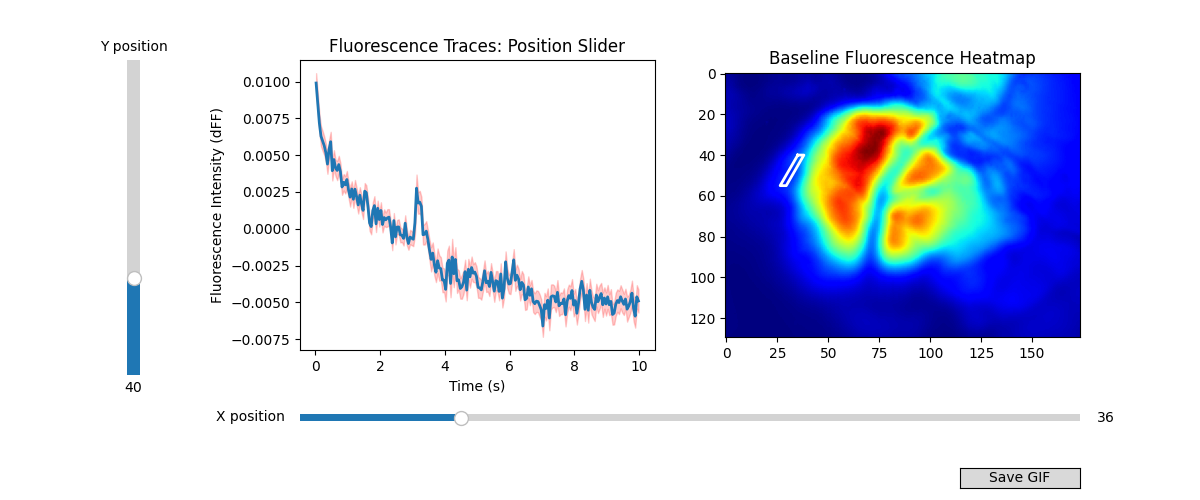

GIF saved as fluorescence_response.gif


In [18]:
# Plot response by function and optionally export as GIF files

import lib.plotting as plotting

%matplotlib widget
plotting.plotDFFSeriesMask(
    imgs, 35, 40, 3, 15, 
    angle=120, 
    Xshift_step=3, 
    Yshift_step=2, 
    X_parallel=True, 
    t_base=(2,3), 
    displayContour=True, 
    Yaxis_range=(-0.01, 0.0125), 
    Xshift_Num=35, 
    Yshift_Num=None, 
    gif_frameDur=1000, 
    gif_name="fluorescence_response.gif"
)
%matplotlib inline